In [1]:
# Load Train and Test datasets

import pandas as pd

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train_ori = [x[0] for x in train_data[['sentiment']].values]
print("Train length:",len(X_train_raw))

X_test_raw = [x[0] for x in test_data[['text']].values]
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [2]:
# Checking the distribution of the sentiments in training data
pd.DataFrame(Y_train_ori, columns=['sentiment'])['sentiment'].value_counts(normalize=True)

neutral     0.580635
positive    0.248968
negative    0.170397
Name: sentiment, dtype: float64

In [3]:
# Obtain baseline accuracy by implementing Zero-R classifier

from sklearn.dummy import DummyClassifier
zero_r = DummyClassifier(strategy='most_frequent')
zero_r.fit(X_train_raw, Y_train_ori)
baseline = zero_r.score(X_train_raw, Y_train_ori)
print('Baseline accuracy: ', baseline)

Baseline accuracy:  0.5806348041464086


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

### H0: Training and Validation on preprocessed tweets using unigrams as features 

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [6]:
# Pre-processing of tweets

X_train_preprocessed = [re.sub(r'http\S+', '', x) for x in X_train_raw] # remove URLs
X_train_preprocessed = [re.sub(r'^@[\w]{4,15}', '', x) for x in X_train_preprocessed] # remove usernames (Twitter usernames are of length 4-15)
X_train_preprocessed = [re.sub('[^A-Za-z0-9 ]+','', x) for x in X_train_preprocessed] # remove non-alphanumeric characters

# Remove stopwords from each tweet
stop = stopwords.words('english')
X_train_preprocessed = [' '.join([word for word in x.split() if word not in stop]) for x in X_train_preprocessed] 

# Perform lemmatization
lemmatizer = WordNetLemmatizer()
X_train_preprocessed = [' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]) for x in X_train_preprocessed] 

In [7]:
# Split the preprocessed training dataset into training and validation sets

X_train, X_val, Y_train, Y_val = train_test_split(X_train_preprocessed, Y_train_ori, test_size=0.2, random_state=0)

In [8]:
tfidf_vectorizer = TfidfVectorizer()

# Build the feature set (vocabulary) and vectorise the Train set using TFIDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Use the feature set (vocabulary) from Train to vectorise the Validation set
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print("Train feature space size (using TFIDF):", X_train_tfidf.shape)

Train feature space size (using TFIDF): (17441, 29737)


In [9]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from numpy import mean, arange
import matplotlib.pyplot as plt

In [10]:
# Add labels to bar graph
def add_value_label(x_list, y_list):
    for i in range(1, len(x_list)+1):
        plt.text(x_list[i-1], y_list[i-1], round(y_list[i-1], 4), ha='center')

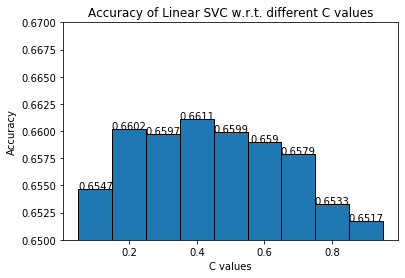

[0.6546663609263931, 0.6601696858518689, 0.6597110754414125, 0.6610869066727815, 0.6599403806466407, 0.659023159825728, 0.6578766337995873, 0.6532905296950241, 0.651685393258427]


In [11]:
# Linear Support Vector Classifier

# Tune values of C to get the value leading to higher accuracy
C = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
acc = []
for c in C:
    clf = LinearSVC(random_state=0, C=c)
    clf.fit(X_train_tfidf, Y_train)
    acc.append(accuracy_score(Y_val, clf.predict(X_val_tfidf)))
    
plt.figure()
plt.bar(C, acc, width=0.1, edgecolor='k')
plt.xlabel('C values')
plt.ylim(0.65,0.67)
plt.ylabel('Accuracy')
plt.title('Accuracy of Linear SVC w.r.t. different C values')
add_value_label(C, acc)
plt.show()

print(acc)

In [12]:
# Select C=0.4 and perform cross validation
clf = LinearSVC(random_state=0, C=0.4)
clf.fit(X_train_tfidf, Y_train)

h0_svc_acc = clf.score(X_val_tfidf, Y_val)
h0_svc_cv = mean(cross_val_score(clf, X_train_tfidf, Y_train, cv=10))
print('Accuracy on validation set: ', h0_svc_acc)
print('Average cross validation score: ', h0_svc_cv)

Accuracy on validation set:  0.6610869066727815
Average cross validation score:  0.6574747640703451


In [13]:
# Multinomial Naive bayes Classifier

mnb = MultinomialNB()
mnb.fit(X_train_tfidf, Y_train)

h0_mnb_acc = mnb.score(X_val_tfidf, Y_val)
h0_mnb_cv = mean(cross_val_score(mnb, X_train_tfidf, Y_train, cv=10))
print('Accuracy on validation set: ', h0_mnb_acc)
print('Average cross validation score: ', h0_mnb_cv)

Accuracy on validation set:  0.5943590919513873
Average cross validation score:  0.599908421177151


In [14]:
# K Nearest Neighbour
# Tuning hyperparameter k
K = [3,5,7,9]
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train_tfidf, Y_train)

    print("Accuracy score using KNN classifier: ", knn.score(X_val_tfidf, Y_val))

Accuracy score using KNN classifier:  0.54918596652144
Accuracy score using KNN classifier:  0.5856454941527173
Accuracy score using KNN classifier:  0.5973400596193533
Accuracy score using KNN classifier:  0.6046778261866544


In [15]:
# Choose k=9 
knn = KNeighborsClassifier(n_neighbors=9, weights='uniform')
knn.fit(X_train_tfidf, Y_train)
h0_knn_acc = knn.score(X_val_tfidf, Y_val)
h0_knn_cv = mean(cross_val_score(knn, X_train_tfidf, Y_train, cv=10))
print('Accuracy on validation set: ', h0_knn_acc)
print('Average cross validation score: ', h0_knn_cv)

Accuracy on validation set:  0.6046778261866544
Average cross validation score:  0.5993351581188717


### H1: Training and Validation on unprocessed tweets using unigrams as features

In [16]:
# Split the unprocessed training dataset into training and validation sets
X_train_up, X_val_up, Y_train_up, Y_val_up = train_test_split(X_train_raw, Y_train_ori, test_size=0.2, random_state=0)

# Vectorize the training and validation sets
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf_up = tfidf_vectorizer.fit_transform(X_train_up)
X_val_tfidf_up = tfidf_vectorizer.transform(X_val_up)

print("Train feature space size:", X_train_tfidf_up.shape)

Train feature space size: (17441, 37682)


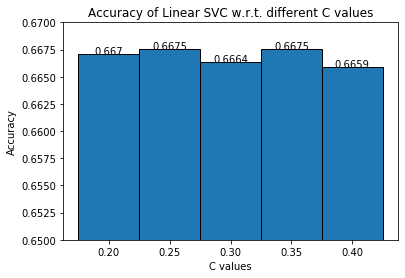

[0.6670488420087136, 0.6675074524191699, 0.6663609263930291, 0.6675074524191699, 0.6659023159825728]


In [17]:
# Linear Support Vector Classifier

# Tune values of C to get the value leading to higher accuracy 
C = [0.2,0.25,0.3,0.35,0.4]
acc = []
for c in C:
    clf = LinearSVC(random_state=0, C=c)
    clf.fit(X_train_tfidf_up, Y_train_up)
    acc.append(accuracy_score(Y_val_up, clf.predict(X_val_tfidf_up)))
    
plt.figure()
plt.bar(C, acc, edgecolor='k', width=0.05)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.ylim(0.65,0.67)
plt.title('Accuracy of Linear SVC w.r.t. different C values')
add_value_label(C, acc)
plt.show()

print(acc)

In [18]:
# Select C=0.35 and perform cross validation (the wider value of C to allow more misclassifications)
clf = LinearSVC(random_state=0, C=0.35)
clf.fit(X_train_tfidf_up, Y_train_up)

h1_svc_acc = accuracy_score(Y_val_up, clf.predict(X_val_tfidf_up))
h1_svc_cv = mean(cross_val_score(clf, X_train_tfidf_up, Y_train_up, cv=10))
print('Accuracy on validation set: ', h1_svc_acc)
print('Average cross validation score: ', h1_svc_cv)

Accuracy on validation set:  0.6675074524191699
Average cross validation score:  0.6591948161194501


In [19]:
# Multinomial Naive Bayes Classifier

mnb = MultinomialNB()
mnb.fit(X_train_tfidf_up, Y_train_up)

h1_mnb_acc = mnb.score(X_val_tfidf_up, Y_val_up)
h1_mnb_cv = mean(cross_val_score(mnb, X_train_tfidf_up, Y_train_up, cv=10))
print('Accuracy on validation set: ', h1_mnb_acc)
print('Average cross validation score: ', h1_mnb_cv)

Accuracy on validation set:  0.580830084842926
Average cross validation score:  0.5909066533477038


In [20]:
# K-Nearest Neighbour Classifier - hyperparameter tuning
K = [3,5,7,9]
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train_tfidf_up, Y_train_up)

    print("Accuracy score using KNN classifier: ", knn.score(X_val_tfidf_up, Y_val_up))

Accuracy score using KNN classifier:  0.5553772070626003
Accuracy score using KNN classifier:  0.5872506305893144
Accuracy score using KNN classifier:  0.5991745012611787
Accuracy score using KNN classifier:  0.6037606053657418


In [21]:
# Choose k=9
knn = KNeighborsClassifier(n_neighbors=9, weights='uniform')
knn.fit(X_train_tfidf_up, Y_train_up)

h1_knn_acc = knn.score(X_val_tfidf_up, Y_val_up)
h1_knn_cv = mean(cross_val_score(knn, X_train_tfidf_up, Y_train_up, cv=10))
print('Accuracy on validation set: ', h1_knn_acc)
print('Average cross validation score: ', h1_knn_cv)

Accuracy on validation set:  0.6037606053657418
Average cross validation score:  0.6012275242501511


### H2: Training and Validation on unprocessed tweets using unigrams and bigrams as features

In [22]:
X_train_ngram, X_val_ngram, Y_train_ngram, Y_val_ngram = train_test_split(X_train_raw, Y_train_ori, test_size=0.2, random_state=0)

vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,2))
X_train_ngram = vectorizer.fit_transform(X_train_ngram)
X_val_ngram = vectorizer.transform(X_val_ngram)

print("Train feature space size:", X_train_ngram.shape)

Train feature space size: (17441, 207482)


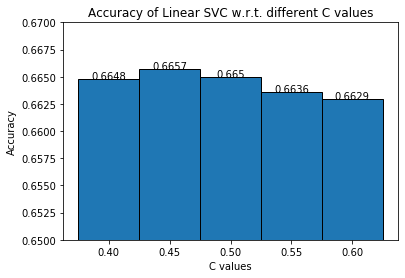

[0.664755789956432, 0.6656730107773446, 0.6649850951616602, 0.6636092639302912, 0.6629213483146067]


In [23]:
# Linear Support Vector Classifier

C = [0.4,0.45,0.5,0.55,0.6]
acc = []
for c in C:
    clf = LinearSVC(random_state=0, C=c)
    clf.fit(X_train_ngram, Y_train_ngram)
    acc.append(accuracy_score(Y_val_ngram, clf.predict(X_val_ngram)))
    
plt.figure()
plt.bar(C, acc, edgecolor='k', width=0.05)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.ylim(0.65,0.67)
plt.title('Accuracy of Linear SVC w.r.t. different C values')
add_value_label(C, acc)
plt.show()
print(acc)

In [24]:
# Select C=0.45 and perform cross validation
clf = LinearSVC(random_state=0, C=0.45)
clf.fit(X_train_ngram, Y_train_ngram)

h2_svc_acc = clf.score(X_val_ngram, Y_val_ngram)
h2_svc_cv = mean(cross_val_score(clf, X_train_ngram, Y_train_ngram, cv=10))
print('Accuracy on validation set: ', h2_svc_acc)
print('Average cross validation score: ', h2_svc_cv)

Accuracy on validation set:  0.6656730107773446
Average cross validation score:  0.6559270261034147


In [25]:
# Multinomial Naive Bayes Classifier

mnb = MultinomialNB()
mnb.fit(X_train_ngram, Y_train_ngram)

h2_mnb_acc = mnb.score(X_val_ngram, Y_val_ngram)
h2_mnb_cv = mean(cross_val_score(mnb, X_train_ngram, Y_train_ngram, cv=10))
print('Accuracy on validation set: ', h2_mnb_acc)
print('Average cross validation score: ', h2_mnb_cv)

Accuracy on validation set:  0.5792249484063289
Average cross validation score:  0.5889570463447333


In [26]:
# K-Nearest Neighbour Classifier - hyperparameter tuning
K = [3,5,7,9]
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train_ngram, Y_train_ngram)

    print("Accuracy score using KNN classifier: ", knn.score(X_val_ngram, Y_val_ngram))

Accuracy score using KNN classifier:  0.547810135290071
Accuracy score using KNN classifier:  0.5849575785370328
Accuracy score using KNN classifier:  0.5900022930520523
Accuracy score using KNN classifier:  0.5952763127723


In [27]:
# Choose k=9
knn = KNeighborsClassifier(n_neighbors=9, weights='uniform')
knn.fit(X_train_ngram, Y_train_ngram)

h2_knn_acc = knn.score(X_val_ngram, Y_val_ngram)
h2_knn_cv = mean(cross_val_score(knn, X_train_ngram, Y_train_ngram, cv=10))
print('Accuracy on validation set: ', h2_knn_acc)
print('Average cross validation score: ', h2_knn_cv)

Accuracy on validation set:  0.5952763127723
Average cross validation score:  0.6060427564995663


### H3: Perform feature selection by Chi-square on unprocessed tweets

In [28]:
from sklearn.feature_selection import SelectKBest, chi2

print("Train feature space size:", X_train_tfidf_up.shape, "\n")

clf = LinearSVC(random_state=0, C=0.35)
x2_acc = []
x2_cv = []
x2_f1 = []

for k in [100,1000,10000,15000]:
    x2 = SelectKBest(chi2, k=k)

    X_train_x2 = x2.fit_transform(X_train_tfidf_up, Y_train_up)
    X_val_x2 = x2.transform(X_val_tfidf_up)
    clf.fit(X_train_x2, Y_train_up)
    y_val_predict = clf.predict(X_val_x2)
    
    acc = clf.score(X_val_x2, Y_val_up)
    cvs = mean(cross_val_score(clf, X_train_x2, Y_train_up, cv=10))
    f1 = f1_score(Y_val_up, y_val_predict, average='weighted')
    
    x2_acc.append(acc)
    x2_cv.append(cvs)
    x2_f1.append(f1)
    
    print('Accuracy on validation when k =', k, ':', acc)
    print('Average cross validation score when k =', k, ':', cvs)
    print('F1 score when k =', k, ':', f1)
    print("\n")

Train feature space size: (17441, 37682) 

Accuracy on validation when k = 100 : 0.6454941527172667
Average cross validation score when k = 100 : 0.6503646394679425
F1 score when k = 100 : 0.6012777851894628


Accuracy on validation when k = 1000 : 0.6670488420087136
Average cross validation score when k = 1000 : 0.6758215806629688
F1 score when k = 1000 : 0.6401725715289673


Accuracy on validation when k = 10000 : 0.6677367576243981
Average cross validation score when k = 10000 : 0.6801226308456665
F1 score when k = 10000 : 0.6438820379794444


Accuracy on validation when k = 15000 : 0.6672781472139417
Average cross validation score when k = 15000 : 0.6773131621145607
F1 score when k = 15000 : 0.6444139823768098




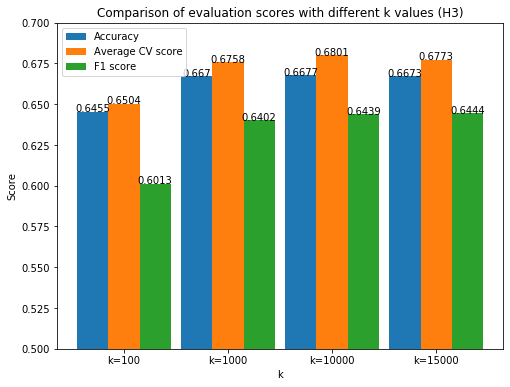

In [29]:
# Visualise feature selection scores

X = ['k=100', 'k=1000', 'k=10000', 'k=15000']
X_axis = arange(len(X))
plt.figure(figsize=(8,6))
plt.bar(X_axis - 0.3, x2_acc, 0.3, label = 'Accuracy')
plt.bar(X_axis, x2_cv, 0.3, label = 'Average CV score')
plt.bar(X_axis + 0.3, x2_f1, 0.3, label = 'F1 score')
plt.xticks(X_axis, X)
plt.xlabel("k")
plt.ylabel("Score")
plt.ylim(0.5,0.7)
plt.title("Comparison of evaluation scores with different k values (H3)")
plt.legend()
add_value_label(X_axis-0.3, x2_acc)
add_value_label(X_axis, x2_cv)
add_value_label(X_axis+0.3, x2_f1)
plt.savefig('figure4.png')
plt.show()

In [30]:
h3_svc_acc = x2_acc[2]
h3_svc_cv = x2_cv[2]

### Prediction on Test set

In [31]:
# Create bar graphs to compare evaluation scores for each hypothesis
scorename = ['Baseline', 'SVC accuracy', 'SVC CV', 'MNB accuracy', 'MNB CV', 'KNN accuracy', 'KNN CV']

scores0 = [baseline, h0_svc_acc, h0_svc_cv, h0_mnb_acc, h0_mnb_cv, h0_knn_acc, h0_knn_cv]
scores1 = [baseline, h1_svc_acc, h1_svc_cv, h1_mnb_acc, h1_mnb_cv, h1_knn_acc, h1_knn_cv]
scores2 = [baseline, h2_svc_acc, h2_svc_cv, h2_mnb_acc, h2_mnb_cv, h2_knn_acc, h2_knn_cv]
#scores3 = [baseline, h3_svc_acc, h3_svc_cv, h3_mnb_acc, h3_mnb_cv, h3_knn_acc, h3_knn_cv]
#scores4 = [baseline, h4_svc_acc, h4_svc_cv, h4_mnb_acc, h4_mnb_cv, h4_knn_acc]

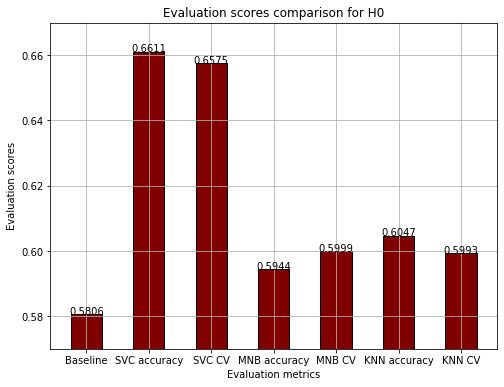

In [32]:
# H0 bar graph

plt.figure(figsize=(8,6))
plt.bar(range(7), scores0, edgecolor='k', width=0.5, color='maroon', tick_label=scorename)
plt.xlabel('Evaluation metrics')
plt.ylabel('Evaluation scores')
plt.ylim(0.57,0.67)
plt.title('Evaluation scores comparison for H0')
add_value_label(range(7), scores0)
plt.grid(True)
#plt.savefig('figure1.png')
plt.show()

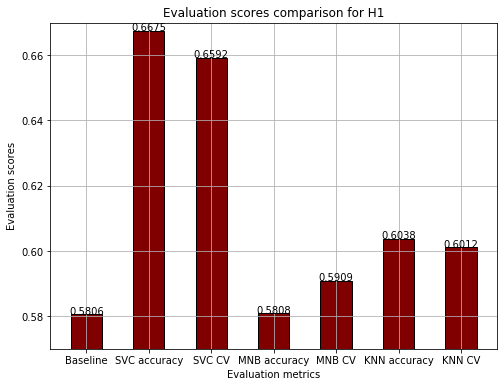

In [33]:
# H1 bar graph

plt.figure(figsize=(8,6))
plt.bar(range(7), scores1, edgecolor='k', width=0.5, color='maroon', tick_label=scorename)
plt.xlabel('Evaluation metrics')
plt.ylabel('Evaluation scores')
plt.ylim(0.57,0.67)
plt.title('Evaluation scores comparison for H1')
add_value_label(range(7), scores1)
plt.grid(True)
#plt.savefig('figure2.png')
plt.show()

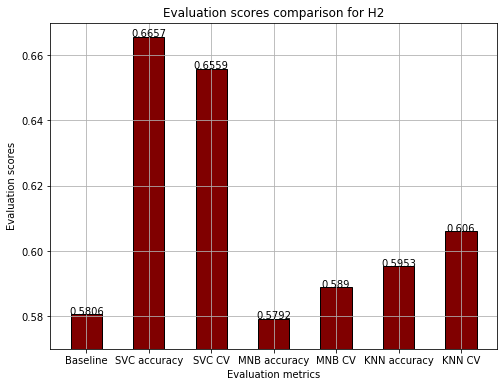

In [34]:
# H2 bar graph

plt.figure(figsize=(8,6))
plt.bar(range(7), scores2, edgecolor='k', width=0.5, color='maroon', tick_label=scorename)
plt.xlabel('Evaluation metrics')
plt.ylabel('Evaluation scores')
plt.ylim(0.57,0.67)
plt.title('Evaluation scores comparison for H2')
add_value_label(range(7), scores2)
plt.grid(True)
#plt.savefig('figure3.png')
plt.show()

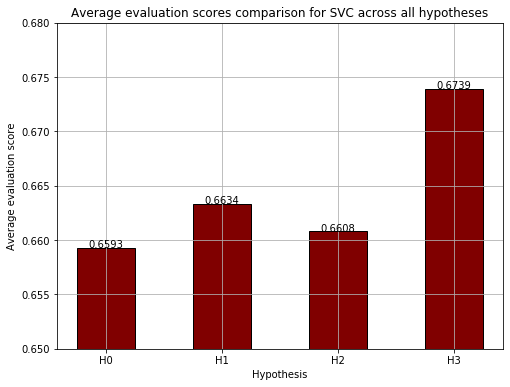

In [35]:
hypothesis = ['H0', 'H1', 'H2', 'H3']
average = [h0_svc_acc+h0_svc_cv, h1_svc_acc+h1_svc_cv, h2_svc_acc+h2_svc_cv, h3_svc_acc+h3_svc_cv]
average = [a/2 for a in average]

plt.figure(figsize=(8,6))
plt.bar(range(4), average, edgecolor='k', width=0.5, color='maroon', tick_label=hypothesis)
plt.xlabel('Hypothesis')
plt.ylabel('Average evaluation score')
plt.ylim(0.65,0.68)
plt.title('Average evaluation scores comparison for SVC across all hypotheses')
add_value_label(range(4), average)
plt.grid(True)
plt.savefig('figure5.png')
plt.show()

In [37]:
# Decision: use raw test dataset vectorised with TfidfVectorizer and select 10000 most correlated features using Chi-square 
# and predict sentiment using Linear SVC with C=0.35

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf_up = tfidf_vectorizer.fit_transform(X_train_up)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

clf = LinearSVC(random_state=0, C=0.35)
x2 = SelectKBest(chi2, k=10000)
X_train_x2 = x2.fit_transform(X_train_tfidf_up, Y_train_up)
X_test_x2 = x2.transform(X_test_tfidf)
clf.fit(X_train_x2, Y_train_up)

prediction = pd.Series(clf.predict(X_test_x2))
output = pd.DataFrame({'id': test_data['id'], 'sentiment': prediction})
print(output['sentiment'].value_counts(normalize=True))
output.to_csv('test_final.csv', index=False, header=True)

neutral     0.691097
positive    0.193146
negative    0.115757
Name: sentiment, dtype: float64
